https://pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/

In [1]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras

In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
#from google.colab.patches import cv2_imshow # cv2.imshow does not work on Google Colab notebooks, which is why we are using cv2_imshow instead

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [12]:
x = tf.Variable(3.0)
print(x)

with tf.GradientTape() as tape:
    y = x**2

dy_dx = tape.gradient(y, x)
dy_dx.numpy()
tf.executing_eagerly()

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.0>


True

In [5]:
w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:
  y = x @ w + b
  loss = tf.reduce_mean(y**2)
  print(loss)

tf.Tensor(7.507063, shape=(), dtype=float32)


In [6]:
layer = tf.keras.layers.Dense(2, activation='relu')
x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
  # Forward pass
  y = layer(x)
  loss = tf.reduce_mean(y**2)

# Calculate gradients with respect to every trainable variable
grad = tape.gradient(loss, layer.trainable_variables)
layer.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(3, 2) dtype=float32, numpy=
 array([[ 0.14869678,  0.37307262],
        [ 0.48102224,  0.7773043 ],
        [-0.74504304, -1.0202215 ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>]

In [7]:
base_model = keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(50, 50, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top

In [8]:
def CNN(input_shape=(50, 50, 3), output_class_count=2):
                
    inputs = layers.Input(shape=input_shape,name='Input')

    x = base_model.get_layer('block1_conv1')(inputs)
    x.trainable=False

    x = base_model.get_layer('block1_conv2')(x)
    x.trainable=False


    x = layers.Conv2D(filters=6, kernel_size=5, strides=1,padding='valid',name='conv1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.MaxPool2D(pool_size=2, strides=2,name='S2')(x)
    

# layer 2
    x = layers.Conv2D(filters=16, kernel_size=5,strides=1,padding='valid',name='conv2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=2, strides=2,name='S4')(x)
    
# layer 3
    x = layers.Conv2D(filters=120, kernel_size=5,strides=1,padding='valid',name='conv3')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Flatten()(x)

    x = layers.Dropout(0.1)(x)
    x = layers.Dense(84, activation='relu',name='F6')(x)
    outputs = layers.Dense(units=output_class_count,activation='softmax',name='Output')(x)
    
    model = keras.Model(inputs, outputs)
    return model

In [9]:
#model = load_model('models/CNN.h5', custom_objects={'f1_score':f1_score})
model = CNN((50, 50, 3), 2)
model.load_weights('weights/CNN_weights.h5')

In [60]:
# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

image = cv2.imread('datasets/breast-histopathology/IDC_regular_ps50_idx5/13689/1/13689_idx5_x801_y1501_class1.png', cv2.IMREAD_COLOR)

image = cv2.resize(image, (50, 50))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

# Its shape is (1, 150, 150, 3)
print(image.shape)
image.max()

(1, 50, 50, 3)


0.9607843

In [39]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h)) #
        #heatmap = tf.image.resize(cam , (w, h))
        
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [14]:
preds = model.predict(image) 
preds

array([[0.01730144, 0.98269856]], dtype=float32)

In [15]:
i = np.argmax(preds[0])
i

1

In [ ]:
for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name)


Input
block1_conv1
block1_conv2
conv1
batch_normalization_6
re_lu_6
S2
conv2
batch_normalization_7
re_lu_7
S4
conv3
batch_normalization_8
re_lu_8
flatten_2
dropout_2
F6
Output


In [48]:
tf.config.run_functions_eagerly(True)
icam = GradCAM(model, i, 'conv3') 
icam

In [49]:
heatmap = icam.compute_heatmap(image)
heatmap.shape

(50, 50)

In [61]:
icam = GradCAM(model, i, 'conv3') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (50, 50))

image = cv2.imread('datasets/breast-histopathology/IDC_regular_ps50_idx5/13689/1/13689_idx5_x801_y1501_class1.png')
image = cv2.resize(image, (50, 50))

print(heatmap.shape, image.shape)
print(heatmap.dtype)

(heatmap, output) = icam.overlay_heatmap(heatmap, image.squeeze(), alpha=0.3)

(50, 50) (50, 50, 3)
uint8


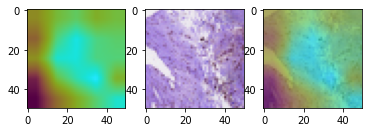

In [62]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image.squeeze())
ax[2].imshow(output)